In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [289]:
class CancerClassifierNet(nn.Module):
    def __init__(self):
        super(CancerClassifierNet, self).__init__()

        self.fc1 = nn.Linear(9, 7) 
        self.fc2 = nn.Linear(7, 5)
        self.fc3 = nn.Linear(5, 3)
        self.fc4 = nn.Linear(3, 1)
        
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(7)
        self.batchnorm2 = nn.BatchNorm1d(5)
        self.batchnorm3 = nn.BatchNorm1d(3)
        self.dropout = nn.Dropout(p = 0.1)
        
    def forward(self, input):
        x = self.relu(self.fc1(input))
        x = self.batchnorm1(x)
        x = self.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.fc3(x))
        x = self.batchnorm3(x)
#         x = self.dropout(x)
        x = self.fc4(x)
        
        return x


In [290]:
col_map = [
    ('sample_code_num', 0),
    ('clump_thickness', 1),
    ('uniformity_cell_size', 1),
    ('uniformity_cell_shape', 1),
    ('marginal_adhesion', 1),
    ('single_epithilial_cell_size', 1),
    ('bare_nuclei', 1),
    ('bland_chromatin', 1),
    ('normal_nucleoli', 1),
    ('mitoses', 1),
    ('cancer_class', 0)
]

meta_df = pd.DataFrame(col_map, columns = ['col_name', 'is_feature'])

all_cols = list(meta_df['col_name'])
feature_cols = list(meta_df[meta_df['is_feature'] == 1]['col_name'])



In [291]:
df = pd.read_csv('/Users/nikhilvs/repos/nyu/deep-rl/data/breast-cancer-wisconsin.data', header = None)
df.columns = all_cols
target_col = 'cancer_class_mapped'

df[target_col] = np.where(df['cancer_class'] == 2, 0, 1)
df.drop(df[df['bare_nuclei'] == '?'].index, inplace = True) 
df = df[feature_cols + [target_col]].drop_duplicates()



In [292]:
X = df[feature_cols]
y = df[target_col]



In [293]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.75
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, 
    y_test, 
    test_size = 0.5
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()


In [294]:
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [295]:

class CancerDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = CancerDataset(
    torch.FloatTensor(X_train), 
    torch.FloatTensor(y_train)
)

val_data = CancerDataset(
    torch.FloatTensor(X_val), 
    torch.FloatTensor(y_val)
)

test_data = CancerDataset(
    torch.FloatTensor(X_test), 
    torch.FloatTensor(y_test)
)


In [296]:
train_loader = DataLoader(
    dataset = train_data, 
    batch_size = BATCH_SIZE
)

val_loader = DataLoader(
    dataset = val_data, 
    batch_size = BATCH_SIZE
)

test_loader = DataLoader(
    dataset = test_data, 
    batch_size = BATCH_SIZE
)



In [297]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CancerClassifierNet()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [298]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_pred.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [299]:
epoch_loss_list = []

for epoch in range(0, EPOCHS):
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_val_loss = 0
    epoch_val_acc = 0
    epoch_test_loss = 0
    epoch_test_acc = 0
    
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_train_acc += acc.item()
    
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            epoch_val_loss += loss.item()
            epoch_val_acc += acc.item()
        
    epoch_loss_list.append((
        epoch,
        epoch_train_loss/len(train_loader),
        epoch_val_loss/len(val_loader)
    ))
    print(f'Epoch = {epoch+0:03} | Train = ({epoch_train_loss/len(train_loader):.5f}, {epoch_train_acc/len(train_loader):.3f}) | Val = ({epoch_val_loss/len(val_loader):.5f}, {epoch_val_acc/len(val_loader):.3f})')

Epoch = 000 | Train = (0.68302, 57.000) | Val = (0.68526, 54.333)
Epoch = 001 | Train = (0.66185, 57.000) | Val = (0.68122, 54.333)
Epoch = 002 | Train = (0.64357, 58.500) | Val = (0.67616, 54.333)
Epoch = 003 | Train = (0.62649, 61.500) | Val = (0.67007, 55.333)
Epoch = 004 | Train = (0.61038, 67.500) | Val = (0.66285, 56.000)
Epoch = 005 | Train = (0.59534, 68.500) | Val = (0.65450, 56.000)
Epoch = 006 | Train = (0.58238, 69.500) | Val = (0.64485, 55.333)
Epoch = 007 | Train = (0.57125, 73.000) | Val = (0.63388, 56.000)
Epoch = 008 | Train = (0.56192, 75.500) | Val = (0.62170, 58.000)
Epoch = 009 | Train = (0.55427, 78.000) | Val = (0.60842, 62.000)
Epoch = 010 | Train = (0.54753, 81.000) | Val = (0.59448, 66.667)
Epoch = 011 | Train = (0.54139, 82.500) | Val = (0.58030, 70.667)
Epoch = 012 | Train = (0.53587, 82.500) | Val = (0.56596, 74.000)
Epoch = 013 | Train = (0.53047, 82.500) | Val = (0.55203, 76.000)
Epoch = 014 | Train = (0.52534, 82.500) | Val = (0.53863, 77.667)
Epoch = 01

Epoch = 137 | Train = (0.25613, 96.000) | Val = (0.25401, 95.333)
Epoch = 138 | Train = (0.25502, 96.000) | Val = (0.25291, 95.333)
Epoch = 139 | Train = (0.25391, 96.000) | Val = (0.25196, 95.333)
Epoch = 140 | Train = (0.25280, 96.000) | Val = (0.25094, 95.333)
Epoch = 141 | Train = (0.25169, 96.000) | Val = (0.24990, 95.333)
Epoch = 142 | Train = (0.25063, 96.000) | Val = (0.24894, 95.333)
Epoch = 143 | Train = (0.24951, 96.000) | Val = (0.24797, 95.333)
Epoch = 144 | Train = (0.24844, 96.000) | Val = (0.24711, 95.333)
Epoch = 145 | Train = (0.24738, 96.000) | Val = (0.24619, 95.333)
Epoch = 146 | Train = (0.24631, 96.000) | Val = (0.24518, 95.333)
Epoch = 147 | Train = (0.24525, 96.000) | Val = (0.24413, 95.333)
Epoch = 148 | Train = (0.24425, 96.000) | Val = (0.24332, 95.333)
Epoch = 149 | Train = (0.24316, 96.500) | Val = (0.24252, 95.333)
Epoch = 150 | Train = (0.24211, 96.500) | Val = (0.24170, 95.333)
Epoch = 151 | Train = (0.24105, 96.500) | Val = (0.24087, 95.333)
Epoch = 15

Epoch = 273 | Train = (0.16636, 96.500) | Val = (0.17372, 94.667)
Epoch = 274 | Train = (0.16600, 96.500) | Val = (0.17319, 94.667)
Epoch = 275 | Train = (0.16563, 96.500) | Val = (0.17262, 94.667)
Epoch = 276 | Train = (0.16526, 96.500) | Val = (0.17205, 94.667)
Epoch = 277 | Train = (0.16489, 96.500) | Val = (0.17157, 94.667)
Epoch = 278 | Train = (0.16452, 96.500) | Val = (0.17106, 94.667)
Epoch = 279 | Train = (0.16418, 96.500) | Val = (0.17112, 94.667)
Epoch = 280 | Train = (0.16384, 96.500) | Val = (0.17135, 94.667)
Epoch = 281 | Train = (0.16346, 96.500) | Val = (0.17121, 94.667)
Epoch = 282 | Train = (0.16311, 96.500) | Val = (0.17087, 94.667)
Epoch = 283 | Train = (0.16276, 96.500) | Val = (0.17038, 94.667)
Epoch = 284 | Train = (0.16240, 96.500) | Val = (0.16990, 94.667)
Epoch = 285 | Train = (0.16204, 96.500) | Val = (0.16931, 94.667)
Epoch = 286 | Train = (0.16169, 96.500) | Val = (0.16869, 94.667)
Epoch = 287 | Train = (0.16133, 96.500) | Val = (0.16808, 94.667)
Epoch = 28

Epoch = 425 | Train = (0.12644, 96.500) | Val = (0.15184, 94.333)
Epoch = 426 | Train = (0.12624, 96.500) | Val = (0.15229, 94.333)
Epoch = 427 | Train = (0.12604, 96.500) | Val = (0.15266, 94.333)
Epoch = 428 | Train = (0.12582, 96.500) | Val = (0.15293, 94.333)
Epoch = 429 | Train = (0.12564, 96.500) | Val = (0.15272, 94.333)
Epoch = 430 | Train = (0.12543, 96.500) | Val = (0.15255, 94.333)
Epoch = 431 | Train = (0.12523, 96.500) | Val = (0.15243, 94.333)
Epoch = 432 | Train = (0.12503, 96.500) | Val = (0.15243, 94.333)
Epoch = 433 | Train = (0.12483, 96.500) | Val = (0.15267, 94.333)
Epoch = 434 | Train = (0.12463, 96.500) | Val = (0.15266, 94.333)
Epoch = 435 | Train = (0.12447, 96.500) | Val = (0.15282, 94.333)
Epoch = 436 | Train = (0.12427, 96.500) | Val = (0.15316, 94.333)
Epoch = 437 | Train = (0.12418, 96.500) | Val = (0.15131, 94.333)
Epoch = 438 | Train = (0.12403, 96.500) | Val = (0.15052, 94.333)
Epoch = 439 | Train = (0.12381, 96.500) | Val = (0.15060, 94.333)
Epoch = 44

Epoch = 560 | Train = (0.10466, 96.500) | Val = (0.19318, 92.333)
Epoch = 561 | Train = (0.10455, 96.500) | Val = (0.19389, 92.333)
Epoch = 562 | Train = (0.10444, 96.500) | Val = (0.19483, 92.333)
Epoch = 563 | Train = (0.10435, 96.500) | Val = (0.19603, 92.333)
Epoch = 564 | Train = (0.10425, 96.500) | Val = (0.19717, 92.333)
Epoch = 565 | Train = (0.10416, 96.500) | Val = (0.19750, 92.333)
Epoch = 566 | Train = (0.10407, 96.500) | Val = (0.19759, 92.333)
Epoch = 567 | Train = (0.10397, 96.500) | Val = (0.19737, 92.333)
Epoch = 568 | Train = (0.10388, 96.500) | Val = (0.19720, 92.333)
Epoch = 569 | Train = (0.10379, 96.500) | Val = (0.19717, 91.667)
Epoch = 570 | Train = (0.10370, 96.500) | Val = (0.19730, 91.667)
Epoch = 571 | Train = (0.10362, 96.500) | Val = (0.19730, 91.667)
Epoch = 572 | Train = (0.10353, 96.500) | Val = (0.19773, 91.667)
Epoch = 573 | Train = (0.10344, 96.500) | Val = (0.19845, 91.667)
Epoch = 574 | Train = (0.10335, 96.500) | Val = (0.19919, 91.667)
Epoch = 57

Epoch = 719 | Train = (0.09541, 96.500) | Val = (0.29132, 88.333)
Epoch = 720 | Train = (0.09562, 96.500) | Val = (0.26748, 89.000)
Epoch = 721 | Train = (0.09595, 96.500) | Val = (0.26293, 88.333)
Epoch = 722 | Train = (0.09595, 96.500) | Val = (0.25998, 89.333)
Epoch = 723 | Train = (0.09121, 97.500) | Val = (0.25326, 90.000)
Epoch = 724 | Train = (0.09125, 97.500) | Val = (0.24933, 90.667)
Epoch = 725 | Train = (0.09112, 97.500) | Val = (0.24846, 90.667)
Epoch = 726 | Train = (0.09051, 98.000) | Val = (0.25188, 90.667)
Epoch = 727 | Train = (0.08979, 98.000) | Val = (0.26232, 90.000)
Epoch = 728 | Train = (0.08901, 98.000) | Val = (0.27141, 89.000)
Epoch = 729 | Train = (0.08871, 98.000) | Val = (0.25828, 88.333)
Epoch = 730 | Train = (0.08822, 98.000) | Val = (0.23632, 91.000)
Epoch = 731 | Train = (0.08815, 98.000) | Val = (0.23083, 90.333)
Epoch = 732 | Train = (0.08786, 98.000) | Val = (0.23199, 90.000)
Epoch = 733 | Train = (0.08756, 98.000) | Val = (0.23273, 90.333)
Epoch = 73

Epoch = 846 | Train = (0.07871, 98.000) | Val = (0.41974, 84.333)
Epoch = 847 | Train = (0.07867, 98.000) | Val = (0.42231, 84.333)
Epoch = 848 | Train = (0.07863, 98.000) | Val = (0.42467, 84.333)
Epoch = 849 | Train = (0.07861, 98.000) | Val = (0.42529, 84.333)
Epoch = 850 | Train = (0.07858, 98.000) | Val = (0.42322, 84.333)
Epoch = 851 | Train = (0.07855, 98.000) | Val = (0.42164, 84.333)
Epoch = 852 | Train = (0.07851, 98.000) | Val = (0.42188, 84.333)
Epoch = 853 | Train = (0.07849, 98.000) | Val = (0.42258, 84.333)
Epoch = 854 | Train = (0.07845, 98.000) | Val = (0.42494, 84.333)
Epoch = 855 | Train = (0.07842, 98.000) | Val = (0.42737, 84.333)
Epoch = 856 | Train = (0.07840, 98.000) | Val = (0.42506, 84.333)
Epoch = 857 | Train = (0.07837, 98.000) | Val = (0.42225, 84.333)
Epoch = 858 | Train = (0.07833, 98.000) | Val = (0.42199, 84.333)
Epoch = 859 | Train = (0.07830, 98.000) | Val = (0.42259, 84.333)
Epoch = 860 | Train = (0.07828, 98.000) | Val = (0.42322, 84.667)
Epoch = 86

Epoch = 982 | Train = (0.07440, 98.000) | Val = (0.37905, 84.667)
Epoch = 983 | Train = (0.07433, 98.000) | Val = (0.38161, 84.667)
Epoch = 984 | Train = (0.07432, 98.000) | Val = (0.38430, 84.667)
Epoch = 985 | Train = (0.07424, 98.000) | Val = (0.38466, 84.667)
Epoch = 986 | Train = (0.07435, 98.000) | Val = (0.37497, 84.667)
Epoch = 987 | Train = (0.07431, 98.000) | Val = (0.36439, 84.667)
Epoch = 988 | Train = (0.07434, 98.000) | Val = (0.35652, 85.333)
Epoch = 989 | Train = (0.07429, 98.000) | Val = (0.34946, 85.333)
Epoch = 990 | Train = (0.07423, 98.000) | Val = (0.34654, 85.333)
Epoch = 991 | Train = (0.07418, 98.000) | Val = (0.34767, 85.333)
Epoch = 992 | Train = (0.07417, 98.000) | Val = (0.35120, 85.333)
Epoch = 993 | Train = (0.07413, 98.000) | Val = (0.35734, 85.333)
Epoch = 994 | Train = (0.07415, 98.000) | Val = (0.36593, 84.667)
Epoch = 995 | Train = (0.07409, 98.000) | Val = (0.37038, 84.667)
Epoch = 996 | Train = (0.07412, 98.000) | Val = (0.37270, 84.667)
Epoch = 99

In [300]:
epoch_loss_df = pd.DataFrame(epoch_loss_list, columns = [
    'epoch',
    'epoch_train_loss',
    'epoch_val_loss'
])


### Loss curve

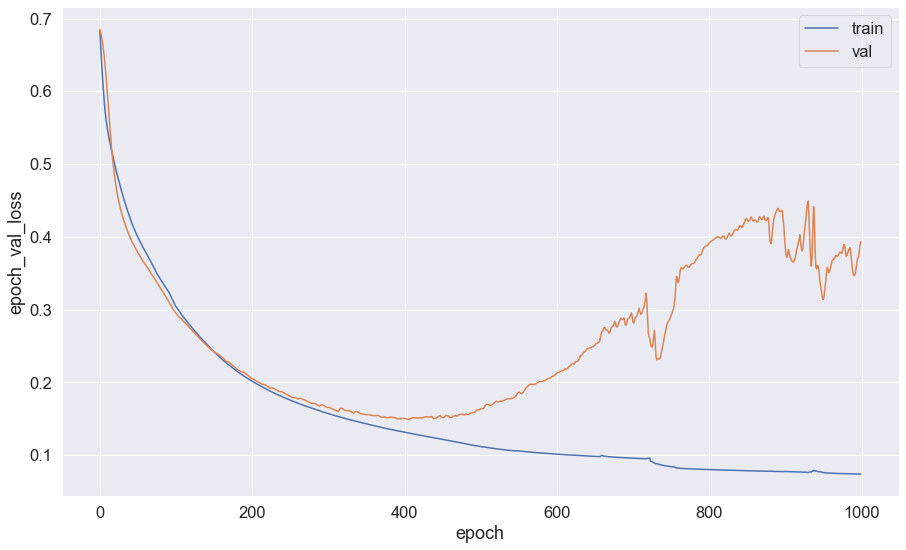

In [301]:
plt.figure(figsize = (15, 9))
sns.set_style('darkgrid')
sns.set(font_scale = 1.5)
sns.lineplot(data = epoch_loss_df, x = 'epoch', y = 'epoch_train_loss', label = 'train')
sns.lineplot(data = epoch_loss_df, x = 'epoch', y = 'epoch_val_loss', label = 'val')



Best Validation loss (0.14988) achieved at epoch 391.

In [260]:
epoch_test_loss = 0
epoch_test_acc = 0

test_preds = []
test_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        epoch_test_loss += loss.item()
        epoch_test_acc += acc.item()

        test_preds.extend(torch.sigmoid(y_pred).data.numpy().tolist())
        test_labels.extend(y_batch.data.numpy().tolist())

test_preds = [item for sublist in test_preds for item in sublist]

test_preds_binary = list(map(lambda x: 1 if x > 0.5 else 0, test_preds))

### ROC Curve

In [261]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_preds_binary)
tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

In [262]:
roc_list = []

for threshold in np.arange(0, 1, 0.01):
    test_preds_binary = list(map(lambda x: 1 if x > threshold else 0, test_preds))
    
    cm = confusion_matrix(test_labels, test_preds_binary)
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    roc_list.append((tpr, fpr, threshold))

roc_df = pd.DataFrame(roc_list, columns = ['tpr', 'fpr', 'threshold'])

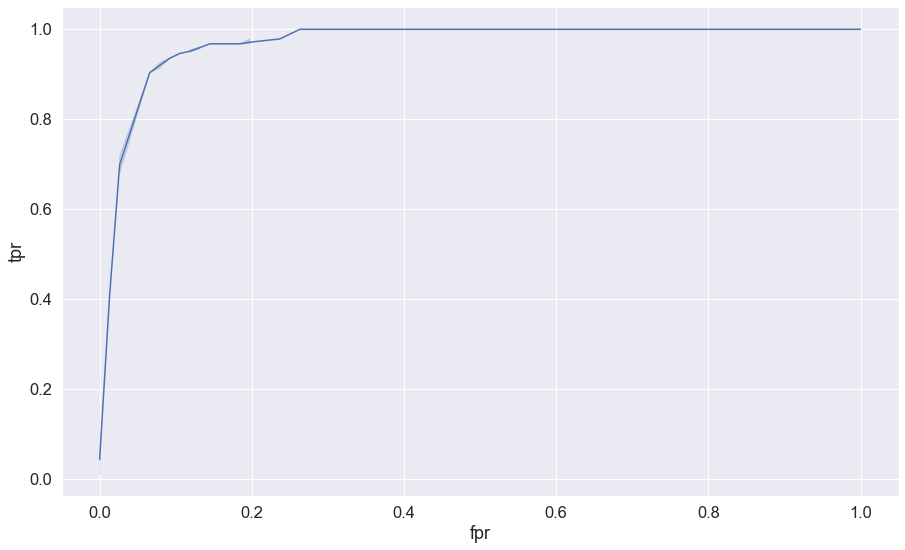

In [263]:
plt.figure(figsize = (15, 9))
sns.lineplot(data = roc_df, x = 'fpr', y = 'tpr')

In [267]:
roc_df[(roc_df['fpr'] >= 0.08) & (roc_df['fpr'] <= 0.1)]

,tpr,fpr,threshold
51,0.935484,0.092105,0.51
52,0.935484,0.092105,0.52
53,0.935484,0.092105,0.53
54,0.935484,0.092105,0.54
55,0.935484,0.092105,0.55
56,0.935484,0.092105,0.56
57,0.935484,0.092105,0.57
58,0.935484,0.092105,0.58
59,0.935484,0.092105,0.59
60,0.935484,0.092105,0.60


### Model selection

Choose threshold = 0.51 for a viable FPR

In [268]:
test_preds_binary = list(map(lambda x: 1 if x > 0.51 else 0, test_preds))
cm = confusion_matrix(test_labels, test_preds_binary)
tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

In [269]:
acc = (tp + tn) / (tp + tn + fp + fn)

### Test Accuracy

In [270]:
acc

0.9230769230769231

### Confusion Matrix - Error Visualization

In [271]:
cm

array([[69,  7],
       [ 6, 87]])

### Tricks tried to improve performance

0. Identifying duplicates in the data to prevent data leakage between train and validation set.
1. Since number of training points is quite less after removing duplicates, we should aim for a simple model. So I first tested a linear model with no non-linearities. I saw performance improvement by introducing non-linearities.
2. Increasing the number of layers while keeping the number of neurons small to control the total number of parameters.
3. Batchnorm regularization to prevent overfitting.
4. Reducing the learning rate.
5. Increasing the number of epochs.
6. Model selection using ROC curve to maintain the FPR within a viable range.